# <center><font size='+3.6'>Ensemble models on Amazon Fine foods reviews dataset.


 * Our objective here is to build the two most popular Ensemble techniques <b> 'Random Forest & Gradient boosted decision trees' classifier to estimate the polarity of a review as Positive/Negative</b> based on the words used in the review.

 * We are given a 500K datset of reviews from Amazon customers regarding the various food products.

 * We will be using 4 different types of Vectorizations to convert text reviews into vectors and we will conclude towards the best Vectorizer based on several performance metrics.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3
import wordcloud
import pickle
import matplotlib.gridspec as gs
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier 
from sklearn import tree
from wordcloud import WordCloud
#from tqdm import tqdm

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [4]:
con=sqlite3.connect('G:\ML\Data_Sets\Amazon\Cleaned_AmazonDB.sqlite')

In [5]:
data=pd.read_sql_query('''Select * from Reviews''',con)

In [9]:
data.shape

(364171, 13)

In [10]:
data['Score'].value_counts()

positive    307061
negative     57110
Name: Score, dtype: int64

Since the data here is imbalanced we will use the <b>class_weight</b> parameter in our DT model as <b>'Balanced'</b>.

## Time based sorting of data:

In [6]:
sorted_data=data.sort_values('Time',axis=0,ascending=True)

In [8]:
sorted_data.head()

,level_0,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,New
0,0,138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,positive,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,witti littl book make son laugh loud recit car...
30,30,138683,150501,0006641040,AJ46FKXOVC7NR,Nicholas A Mesiano,2,2,positive,940809600,This whole series is great way to spend time w...,I can remember seeing the show when it aired o...,rememb see show air televis year child sister ...
424,424,417839,451856,B00004CXX9,AIUWLEQ1ADEG5,Elizabeth Medina,0,0,positive,944092800,Entertainingl Funny!,Beetlejuice is a well written movie ..... ever...,beetlejuic well written movi everyth excel act...
330,330,346055,374359,B00004CI84,A344SMIA5JECGM,Vincent P. Ross,1,2,positive,944438400,A modern day fairy tale,"A twist of rumplestiskin captured on film, sta...",twist rumplestiskin captur star michael keaton...
423,423,417838,451855,B00004CXX9,AJH6LUC1UT1ON,The Phantom of the Opera,0,0,positive,946857600,FANTASTIC!,Beetlejuice is an excellent and funny movie. K...,beetlejuic excel funni movi keaton hilari wack...


## Splitting of Test and Train data

In [7]:
train_length=round(0.7*len(data))
print(train_length)
test_length=round(0.3*len(data))
print(test_length)
print((train_length+test_length)==len(data))

254920
109251
True


In [8]:
train=sorted_data.head(train_length)
test=sorted_data.tail(test_length)

In [10]:
print('\nTrain ratio \n ')
print(train['Score'].value_counts())
print('\nTest ratio \n ')
print(test['Score'].value_counts())


Train ratio 
 
positive    216891
negative     38029
Name: Score, dtype: int64

Test ratio 
 
positive    90170
negative    19081
Name: Score, dtype: int64


## Grid Search CV

In [9]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import TimeSeriesSplit

In [14]:
def GB_grid(x,list_estimators=[10,25,50,100,200],list_depth=[1,3,5,7,9]):
    '''
    Program to return optimal number of base learners of the Random forest.
    '''
    ts=TimeSeriesSplit(n_splits=3)
    par=[{'n_estimators':list_estimators,'max_depth':list_depth}]
    GB=XGBClassifier(random_state=33,scale_pos_weight=0.25)
    grid=GridSearchCV(GB,par,cv=ts.split(x),scoring='f1_micro',verbose=2,n_jobs=-1)
    return grid

In [15]:
def RF_grid(x,list_estimators=[5,10,20,30,50,75],list_depth=[10,20,25,30,40,50]):
    '''
    Program to return optimal number of base learners of the Random forest.
    '''
    ts=TimeSeriesSplit(n_splits=3)
    par=[{'n_estimators':list_estimators,'max_depth':list_depth}]
    rf=RandomForestClassifier(class_weight='balanced')
    grid=GridSearchCV(rf,par,cv=ts.split(x),scoring='f1_micro',verbose=1,n_jobs=-1)
    return grid

## Randomized Search CV

In [13]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform

In [14]:
def RF_random(x):
    '''
    Program to return optimal number of base learners of the Random forest using Random search CV.
    '''
    ts=TimeSeriesSplit(n_splits=10)
    par={'n_estimators': np.random.randint(3,50,5)}    
    rf=RandomForestClassifier(class_weight='balanced')
    rand=RandomizedSearchCV(rf,par,cv=ts.split(x),scoring='accuracy',verbose=1,n_iter=5)
    return rand

## CV Plotter:

In [15]:
def plotter(x):
    '''
    To plot CV error with different values of depth for Random forest classifier.
    '''
    tmp=pd.DataFrame(x.cv_results_)
    plt.figure(figsize=(10,5))
    sns.set_style('darkgrid')
    plt.plot(tmp['param_n_estimators'],1-tmp['mean_test_score'],label='CV Error')
    plt.plot(tmp['param_n_estimators'],1-tmp['mean_train_score'],label='Train Error')    
    plt.xlabel('No of estimators --> ')
    plt.ylabel('Error-->')
    plt.title('Variation in CV & Train error')
    plt.legend()
    plt.show()
    

In [9]:
def GBDT_heatmap(grid,type=3):
    '''
    To plot heat map for GBDT between CV error vs depth & n_estimators
    '''
    tmp=pd.DataFrame(grid.cv_results_)
    a=tmp[['param_max_depth','param_n_estimators','mean_test_score','mean_train_score']]
    
    if(type==1):
        error=np.array(np.round(1-a['mean_test_score'].values.copy(),4))
        error.resize(6,6)
        #plt.figure(figsize=(7,5))
    elif(type==2):
        error=np.array(np.round(1-a['mean_train_score'].values.copy(),4))
        error.resize(6,6) 
        #plt.figure(figsize=(7,5))
    elif(type==3):
        error=np.array(np.round(a['mean_train_score']-a['mean_test_score'],4))
        error.resize(6,6) 
        #plt.figure(figsize=(,5))
        
    #plt.figure(figsize=(8,))
    depth=a['param_max_depth'].unique()
    n_est=a['param_n_estimators'].unique()
    sns.heatmap(error,cmap="Blues",annot=error,fmt='',xticklabels=n_est,yticklabels=depth,cbar=False)
   

In [10]:
def error_plots(x):
    '''
    To plot CV errors of train,CV and their differences
    '''
    g=gs.GridSpec(2,2)
    a=plt.figure(figsize=(12,8))
    plt.subplot(g[0,0])
    GBDT_heatmap(x,1)
    plt.title('CV Error',fontsize=11.5)
    plt.subplot(g[0,1])
    GBDT_heatmap(x,2)
    plt.title('Train Error',fontsize=11.5)
    plt.subplot(g[1,:])    
    plt.subplots_adjust(hspace=0.5)
    GBDT_heatmap(x,3)
    plt.title('Difference between train and test errors',fontsize=14)
    a.text(0.5, 0.03, 'No of estimator(s)', ha='center',fontsize=16)
    a.text(0.04, 0.5, 'Depth of Base learners', va='center', rotation='vertical',fontsize=16)
    a.suptitle('CV plots for different values of Depth and no of estimators',fontsize=19)

## Feature importance:

In [11]:
def feat_importance(model,vectorizer):
    '''
    To return top 20 features from a model
    '''
    imp=model.feature_importances_
    top=imp.argsort()[::-1]
    print('Top 20 important features are : \n')
    top_20=''
    for i in range(20):
        tmp=np.take(vectorizer.get_feature_names(),top[i])
        top_20=top_20+tmp+' '  
    wc=WordCloud(width=900,height=700,background_color='black').generate(top_20)
    plt.figure(figsize=(6,6))
    plt.imshow(wc)
    plt.axis('off')

## Confusion Matrix & Performance Analyser:

In [9]:
def CM(x,y,x1,y1):
    '''
    Function to plot confusion matrix and measure performance of a model
    '''
    CM_Matrix=confusion_matrix(x,y)
    CM_Matrix_train=confusion_matrix(x1,y1)
    print('\n******************************************************************************* \n')
    print(f' Accuracy of train is {accuracy_score(x1,y1)}\n')
    print(f' Accuracy of test is {accuracy_score(x,y)}')
    print('\n******************************************************************************* \n')
    
    #print(f" TNR value is {tn/(tn+fn)}")
    #print(f" FNR value is {fn/(tn+fn)}")
    #print(f" FPR value is {fp/(tp+fp)}")
    #print(f" TPR value is {tp/(tp+fp)}")
    
    
    print('Classification report of train is \n')
    print(classification_report(x1,y1,target_names=['Negative','Positive']))
    print('\n******************************************************************************* \n')
    print('Classification report of test is \n')
    print(classification_report(x,y,target_names=['Negative','Positive']))
    
    print('\n******************************************************************************* \n')
    print('Heat Map of the Confusion matrix is')
    g=gs.GridSpec(1,2)
    a=plt.figure(figsize=(15,5))
    plt.subplot(g[0,0])
    tmp=pd.DataFrame(CM_Matrix)
    tn,fp,fn,tp=CM_Matrix.ravel()
    ann=np.array([['True Negative = '+str(tn),'False Positive = '+str(fp)],['False Negative = '+str(fn),'True Positive = '+str(tp)]])
    sns.heatmap(tmp,annot=ann,fmt='',cmap="YlGnBu")
    plt.title('Confusion Matrix of test')
    
    plt.subplot(g[0,1])
    tmp=pd.DataFrame(CM_Matrix_train)
    tn,fp,fn,tp=CM_Matrix_train.ravel()
    ann=np.array([['True Negative = '+str(tn),'False Positive = '+str(fp)],['False Negative = '+str(fn),'True Positive = '+str(tp)]])
    sns.heatmap(tmp,annot=ann,fmt='',cmap="Greens")
    plt.title('Confusion Matrix of train')
    
    print('\n******************************************************************************* \n')
    
    

# 1.) Bag Of Words Vectorization:

In [10]:
BOW=CountVectorizer(min_df=2)
BOW.fit(train['New'])

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=2,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

In [11]:
BOW_train= BOW.transform(train['New'])
BOW_test=BOW.transform(test['New'])

In [14]:
BOW_train.shape

(254920, 28694)

In [12]:
scaler=StandardScaler(with_mean=False)
std_BOW_train=scaler.fit_transform(BOW_train)
std_BOW_test=scaler.transform(BOW_test)

### Cross Validation :

Since the error seems to be well saturated after 30, we can decrease the range of # estimators to 30 and check if we can observe a better plot.

In [32]:
BOW_grid=RF_grid(std_BOW_train[0:100000])

In [33]:
BOW_grid.fit(std_BOW_train[0:100000],train['Score'][0:100000])

Fitting 10 folds for each of 9 candidates, totalling 90 fits


[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed: 101.0min finished


GridSearchCV(cv=<generator object TimeSeriesSplit.split at 0x000002B320ABABA0>,
       error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid=[{'n_estimators': range(3, 30, 3)}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=1)

In [34]:
BOW_grid.best_estimator_

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=12, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [35]:
BOW_grid.best_score_

0.8903300330033004

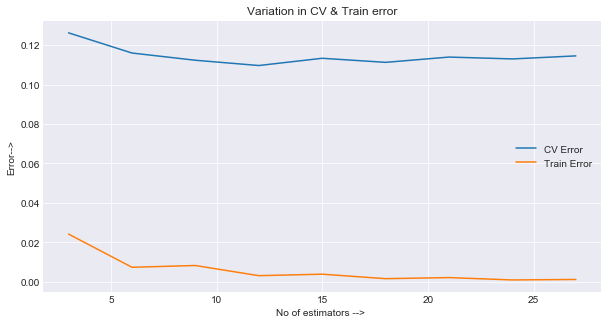

In [36]:
plotter(BOW_grid)

### Implementation:

#### The optimal number of estimators chosen from CV plot is 12 as CV error is decreasing and increasing afterwards.

In [16]:
rf=RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=12, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [17]:
rf.fit(std_BOW_train,train['Score'])

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=12, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [18]:
pred=rf.predict(std_BOW_test)
pred1=rf.predict(std_BOW_train)


******************************************************************************* 

 Accuracy of train is 0.9974227208536012

 Accuracy of test is 0.8730171806207724

******************************************************************************* 

Classification report of train is 

             precision    recall  f1-score   support

   Negative       1.00      0.98      0.99     38029
   Positive       1.00      1.00      1.00    216891

avg / total       1.00      1.00      1.00    254920


******************************************************************************* 

Classification report of test is 

             precision    recall  f1-score   support

   Negative       0.81      0.35      0.49     19081
   Positive       0.88      0.98      0.93     90170

avg / total       0.87      0.87      0.85    109251


******************************************************************************* 

Heat Map of the Confusion matrix is

************************************************

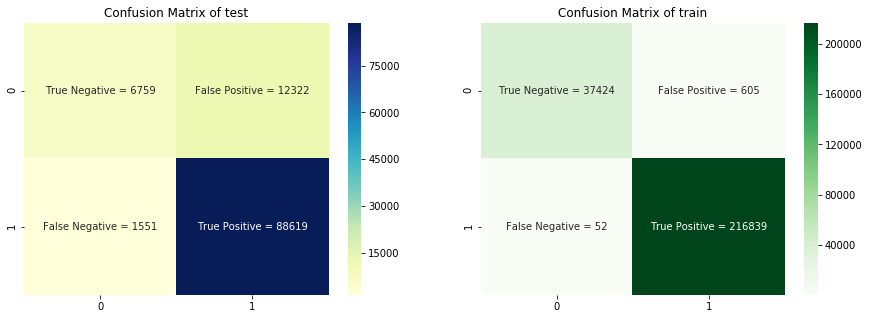

In [31]:
CM(test['Score'],pred,train['Score'],pred1)

Since the above model slightly seem to be overfitting as more points are classified as positive class. Lets decrease the no of estimators to 6 as it was the first inflection point.

In [32]:
rf=RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=6, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [33]:
rf.fit(std_BOW_train,train['Score'])

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=6, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [49]:
pred=rf.predict(std_BOW_test)
pred1=rf.predict(std_BOW_train)


******************************************************************************* 

 Accuracy of train is 0.9974227208536012

 Accuracy of test is 0.8730171806207724

******************************************************************************* 

Classification report of train is 

             precision    recall  f1-score   support

   Negative       1.00      0.98      0.99     38029
   Positive       1.00      1.00      1.00    216891

avg / total       1.00      1.00      1.00    254920


******************************************************************************* 

Classification report of test is 

             precision    recall  f1-score   support

   Negative       0.81      0.35      0.49     19081
   Positive       0.88      0.98      0.93     90170

avg / total       0.87      0.87      0.85    109251


******************************************************************************* 

Heat Map of the Confusion matrix is

************************************************

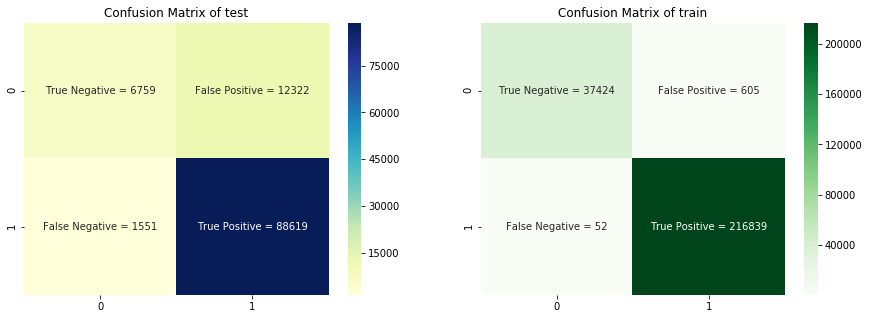

In [34]:
CM(test['Score'],pred,train['Score'],pred1)

Thats a good improvement for True negatives and f1 score of negative is better than earlier. Still there is an overfitting issue as evident from confusion matrix of train. Lets not grow each base learners to full depth and observe what's happening with lower depth on each decision trees. Lets take depth as 20 on a random for now.

In [35]:
rf=RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=20, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [36]:
rf.fit(std_BOW_train,train['Score'])

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=20, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [37]:
pred=rf.predict(std_BOW_test)
pred1=rf.predict(std_BOW_train)


******************************************************************************* 

 Accuracy of train is 0.8335713164914483

 Accuracy of test is 0.8035166726162689

******************************************************************************* 

Classification report of train is 

             precision    recall  f1-score   support

   Negative       0.46      0.73      0.57     38029
   Positive       0.95      0.85      0.90    216891

avg / total       0.88      0.83      0.85    254920


******************************************************************************* 

Classification report of test is 

             precision    recall  f1-score   support

   Negative       0.46      0.70      0.55     19081
   Positive       0.93      0.83      0.87     90170

avg / total       0.85      0.80      0.82    109251


******************************************************************************* 

Heat Map of the Confusion matrix is

************************************************

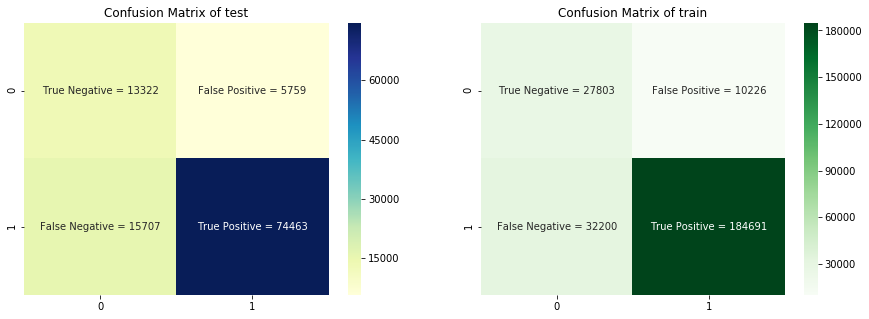

In [38]:
CM(test['Score'],pred,train['Score'],pred1)

From the above one, it is clear that by <b>decreasing the depth of base learners we can avoid overfitting </b>, Hence we will consider Max depth as also a hyperparameter and perform CV to find optimal values.

In [27]:
BOW_grid=RF_grid(std_BOW_train[0:100000])

In [28]:
BOW_grid.fit(std_BOW_train[0:100000],train['Score'][0:100000])

Fitting 3 folds for each of 36 candidates, totalling 108 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 108 out of 108 | elapsed:  5.8min finished


GridSearchCV(cv=<generator object TimeSeriesSplit.split at 0x7f72b099f258>,
       error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators='warn', n_jobs=None, oob_score=False,
            random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid=[{'n_estimators': [5, 10, 20, 30, 50, 75], 'max_depth': [10, 20, 25, 30, 40, 50]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='f1_micro', verbose=1)

In [29]:
BOW_grid.best_estimator_

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=50, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=75, n_jobs=None, oob_score=False,
            random_state=None, verbose=0, warm_start=False)

In [30]:
BOW_grid.best_score_

0.8994933333333334

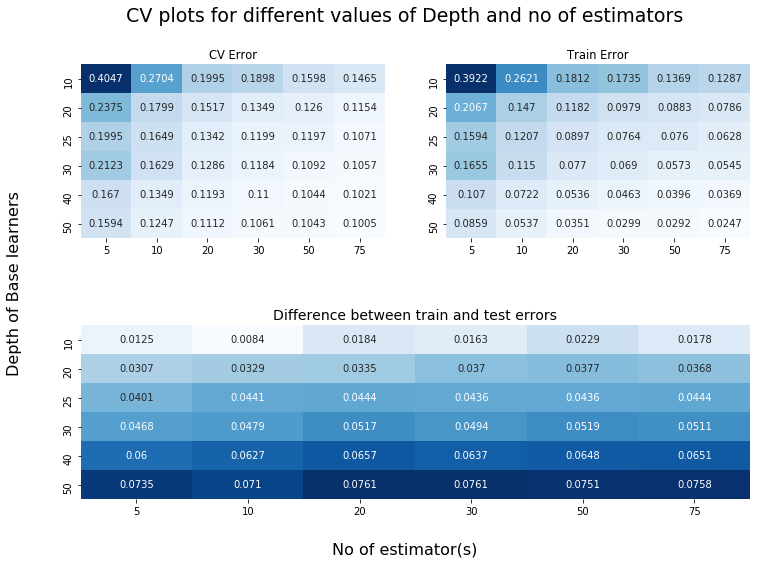

In [31]:
error_plots(BOW_grid)

From the above plot, In CV Error we can see an inflection at number of estimators= 30 as the error value is slowly decreasing after that. <b> Hence lets select n-estimators as 30 </b>. On the column of no of estimator as 30, the values of error decrease steadily till depth 25 after which the reduction is slower. So <b> max_depth can be selected as 25</b>. 

In [24]:
rf=RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=25, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=30, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [25]:
rf.fit(std_BOW_train,train['Score'])

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=25, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=30, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [26]:
pred=rf.predict(std_BOW_test)
pred1=rf.predict(std_BOW_train)

## Performace of Random forest model with BOW_unigram:


******************************************************************************* 

 Accuracy of train is 0.8844617919347246

 Accuracy of test is 0.8503080063340381

******************************************************************************* 

Classification report of train is 

             precision    recall  f1-score   support

   Negative       0.58      0.83      0.68     38029
   Positive       0.97      0.89      0.93    216891

avg / total       0.91      0.88      0.89    254920


******************************************************************************* 

Classification report of test is 

             precision    recall  f1-score   support

   Negative       0.55      0.76      0.64     19081
   Positive       0.94      0.87      0.91     90170

avg / total       0.88      0.85      0.86    109251


******************************************************************************* 

Heat Map of the Confusion matrix is

************************************************

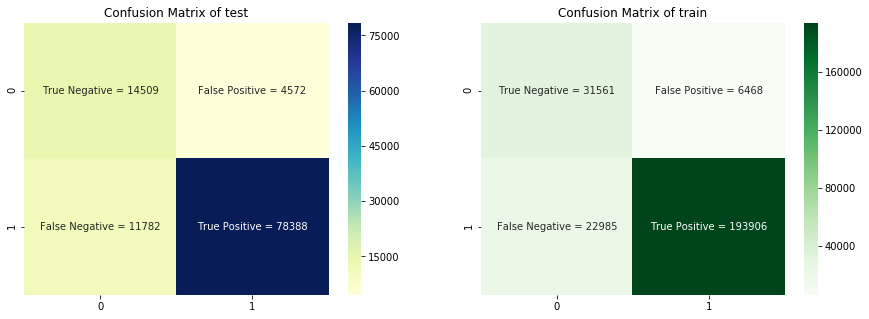

In [27]:
CM(test['Score'],pred,train['Score'],pred1)

Thus the performace of our model is good and more number of true positives and true negatives proves us that our model is peforming well.

## Feature Importance:

Top 20 important features are : 



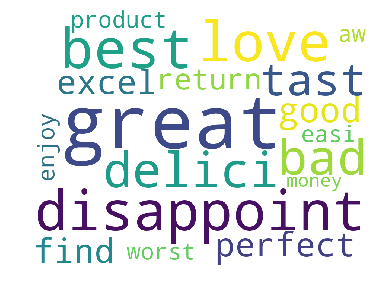

In [51]:
feat_importance(rf,BOW)

## GBDT

### Cross Validation :

In [32]:
BOW_grid=GB_grid(std_BOW_train[0:100000])

In [33]:
BOW_grid.fit(std_BOW_train[0:100000],train['Score'][0:100000])

Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 125 out of 125 | elapsed: 16.2min finished


GridSearchCV(cv=<generator object TimeSeriesSplit.split at 0x7f72aa48b518>,
       error_score='raise-deprecating',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic',
       random_state=33, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=1),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid=[{'n_estimators': [10, 25, 50, 100, 200], 'max_depth': [1, 3, 5, 7, 9]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='f1_micro', verbose=2)

In [34]:
BOW_grid.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=9, min_child_weight=1, missing=None, n_estimators=200,
       n_jobs=1, nthread=None, objective='binary:logistic',
       random_state=33, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=1)

In [35]:
BOW_grid.best_score_

0.9109204368174727

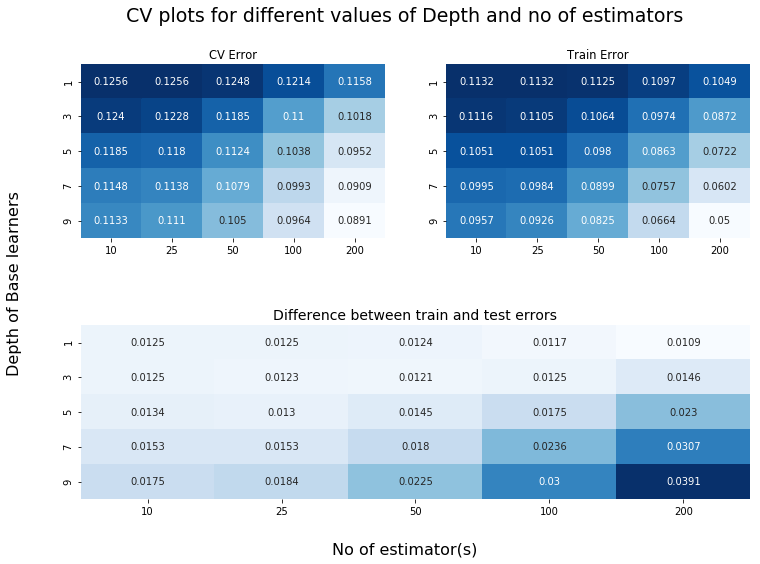

In [40]:
error_plots(BOW_grid)

I chose the hyperparameter values to be as, <b> Depth = 3 and No of estimators = 50</b>, as we can see that it is where the error value gets inflection and then decrease slowly both row wise as well as column wise.

Since the data is imbalanced, all points are classified towards positive class.

* positive    216891
* negative     38029

So lets choose the <b> scale_pos_weight parameter to be 0.25 </b>

### Implementation:

In [96]:
BOW_GB=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=50,
       n_jobs=1, nthread=None, objective='binary:logistic',
       random_state=33, reg_alpha=0, reg_lambda=1, scale_pos_weight=0.25,
       seed=None, silent=True, subsample=1)

In [97]:
BOW_GB.fit(std_BOW_train,train['Score'])

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=50,
       n_jobs=1, nthread=None, objective='binary:logistic',
       random_state=33, reg_alpha=0, reg_lambda=1, scale_pos_weight=0.25,
       seed=None, silent=True, subsample=1)


******************************************************************************* 

 Accuracy of train is 0.8593754903499137

 Accuracy of test is 0.8453286468773741

******************************************************************************* 

Classification report of train is 

             precision    recall  f1-score   support

   Negative       0.53      0.54      0.54     38029
   Positive       0.92      0.91      0.92    216891

avg / total       0.86      0.86      0.86    254920


******************************************************************************* 

Classification report of test is 

             precision    recall  f1-score   support

   Negative       0.56      0.56      0.56     19081
   Positive       0.91      0.91      0.91     90170

avg / total       0.85      0.85      0.85    109251


******************************************************************************* 

Heat Map of the Confusion matrix is

************************************************

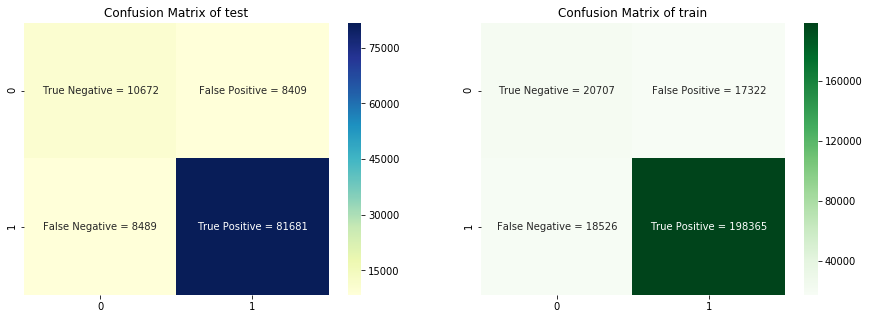

In [98]:
pred=BOW_GB.predict(std_BOW_test)
pred1=BOW_GB.predict(std_BOW_train)
CM(test['Score'],pred,train['Score'],pred1)

## Performace of Gradient Boosted Decision Tree model with BOW_unigram:


******************************************************************************* 

 Accuracy of train is 0.8593754903499137

 Accuracy of test is 0.8453286468773741

******************************************************************************* 

Classification report of train is 

             precision    recall  f1-score   support

   Negative       0.53      0.54      0.54     38029
   Positive       0.92      0.91      0.92    216891

avg / total       0.86      0.86      0.86    254920


******************************************************************************* 

Classification report of test is 

             precision    recall  f1-score   support

   Negative       0.56      0.56      0.56     19081
   Positive       0.91      0.91      0.91     90170

avg / total       0.85      0.85      0.85    109251


******************************************************************************* 

Heat Map of the Confusion matrix is

************************************************

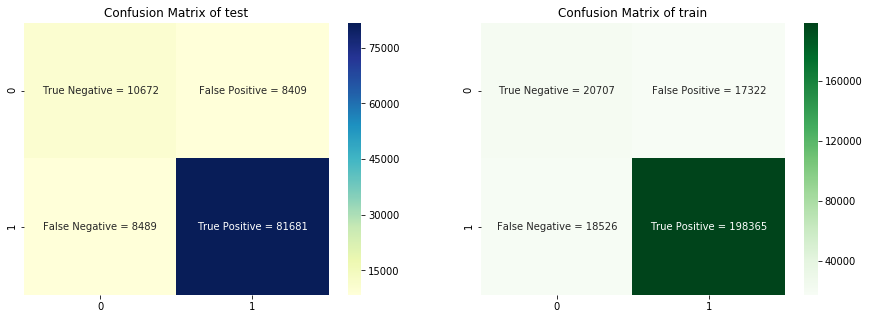

In [99]:
CM(test['Score'],pred,train['Score'],pred1)

## Feature Importance:

Top 20 important features are : 



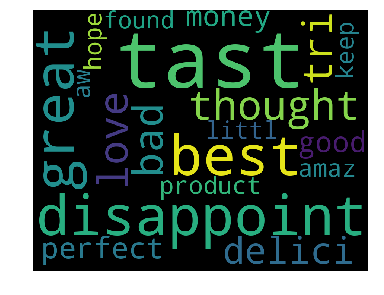

In [63]:
feat_importance(BOW_GB,BOW)

# 2.) TF-IDF Vectorization:

In [28]:
tfidf=TfidfVectorizer(dtype='float',min_df=2)
tfidf.fit(train['New'])

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype='float', encoding='utf-8', input='content', lowercase=True,
        max_df=1.0, max_features=None, min_df=2, ngram_range=(1, 1),
        norm='l2', preprocessor=None, smooth_idf=True, stop_words=None,
        strip_accents=None, sublinear_tf=False,
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
        vocabulary=None)

In [29]:
tfidf_train= tfidf.transform(train['New'])
tfidf_test= tfidf.transform(test['New'])

In [18]:
tfidf_train.shape

(254920, 28694)

In [30]:
scaler=StandardScaler(with_mean=False)
std_tfidf_train=scaler.fit_transform(tfidf_train)
std_tfidf_test=scaler.transform(tfidf_test)

### Cross validation :

In [27]:
t_grid=RF_grid(std_tfidf_train[:100000])

In [28]:
t_grid.fit(std_tfidf_train[:100000],train['Score'][:100000])

Fitting 3 folds for each of 36 candidates, totalling 108 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 108 out of 108 | elapsed:  6.0min finished


GridSearchCV(cv=<generator object TimeSeriesSplit.split at 0x7fe2763c95c8>,
       error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators='warn', n_jobs=None, oob_score=False,
            random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid=[{'n_estimators': [5, 10, 20, 30, 50, 75], 'max_depth': [10, 20, 25, 30, 40, 50]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='f1_micro', verbose=1)

In [29]:
t_grid.best_estimator_

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=40, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=75, n_jobs=None, oob_score=False,
            random_state=None, verbose=0, warm_start=False)

In [30]:
t_grid.best_score_

0.9032266666666666

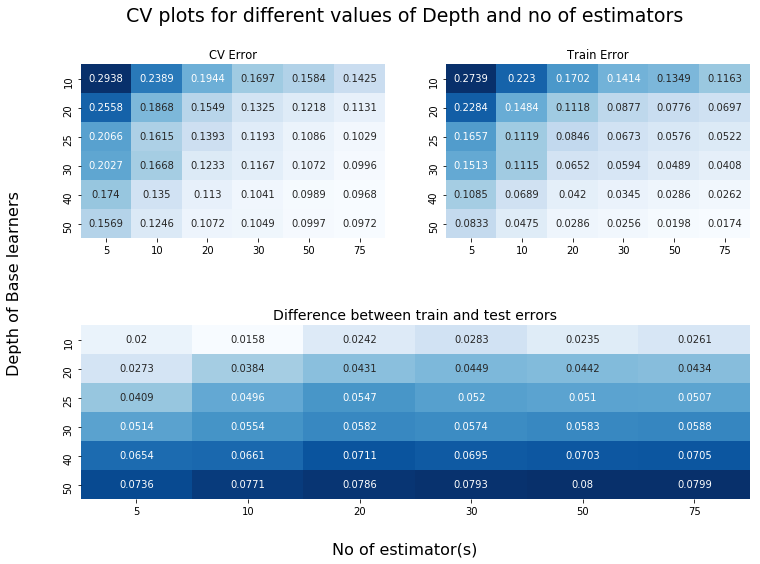

In [31]:
error_plots(t_grid)

From the above CV error plot, we can observe that until no of estimators = 20, the error falls sharply, post which it reduces slowly. Hence we can fix our <b> No of estimators as 20</b>. Similarly sudden fall of error between depth 10 and 20 and after 20 the error is gradually decreasing for all values. So <b> Depth of base learners can be chosen as 20</b>.

### Implementation:

In [35]:
tfidf_model=RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=25, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=30, n_jobs=1, oob_score=False, random_state=33,
            verbose=0, warm_start=False)


In [36]:
tfidf_model.fit(std_tfidf_train,train['Score'])

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=25, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=30, n_jobs=1, oob_score=False, random_state=33,
            verbose=0, warm_start=False)

In [37]:
pred=tfidf_model.predict(std_tfidf_test)
pred1=tfidf_model.predict(std_BOW_train)

## Performace of RF model with TF-IDF:


******************************************************************************* 

 Accuracy of train is 0.8906441236466343

 Accuracy of test is 0.8518823626328363

******************************************************************************* 

Classification report of train is 

             precision    recall  f1-score   support

   Negative       0.61      0.73      0.67     38029
   Positive       0.95      0.92      0.93    216891

avg / total       0.90      0.89      0.89    254920


******************************************************************************* 

Classification report of test is 

             precision    recall  f1-score   support

   Negative       0.56      0.74      0.64     19081
   Positive       0.94      0.88      0.91     90170

avg / total       0.87      0.85      0.86    109251


******************************************************************************* 

Heat Map of the Confusion matrix is

************************************************

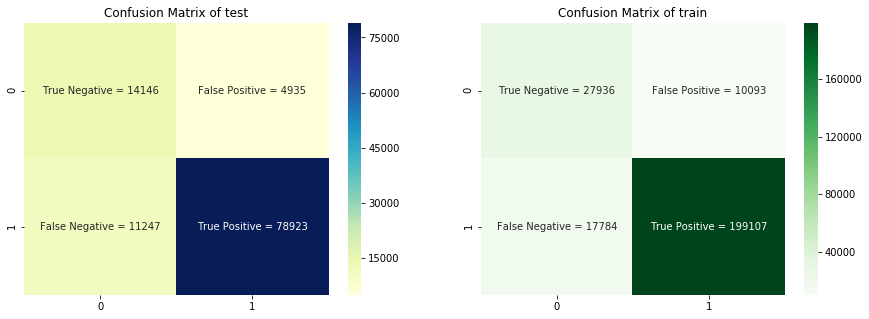

In [38]:
CM(test['Score'],pred,train['Score'],pred1)

## Feature Importance:

Top 20 important features are : 



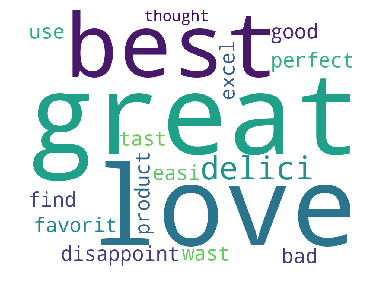

In [113]:
feat_importance(tfidf_model,tfidf)

### GBDT

### Cross Validation :

In [22]:
tfidf_grid=GB_grid(std_tfidf_train[0:100000])

In [23]:
tfidf_grid.fit(std_tfidf_train[0:100000],train['Score'][0:100000])

Fitting 3 folds for each of 25 candidates, totalling 75 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed: 14.4min finished


GridSearchCV(cv=<generator object TimeSeriesSplit.split at 0x7f138e217e60>,
       error_score='raise-deprecating',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic',
       random_state=33, reg_alpha=0, reg_lambda=1, scale_pos_weight=0.25,
       seed=None, silent=True, subsample=1),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid=[{'n_estimators': [10, 25, 50, 100, 200], 'max_depth': [1, 3, 5, 7, 9]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='f1_micro', verbose=2)

In [24]:
tfidf_grid.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=9, min_child_weight=1, missing=None, n_estimators=200,
       n_jobs=1, nthread=None, objective='binary:logistic',
       random_state=33, reg_alpha=0, reg_lambda=1, scale_pos_weight=0.25,
       seed=None, silent=True, subsample=1)

In [25]:
tfidf_grid.best_score_

0.9024533333333333

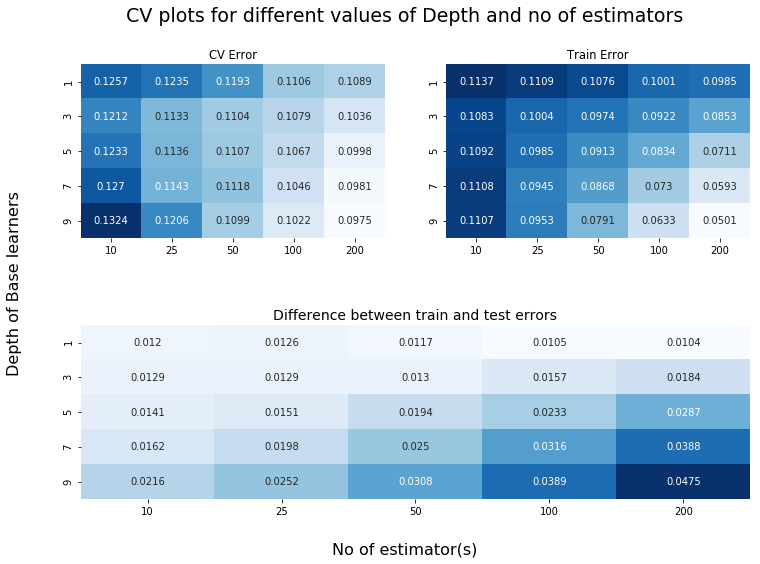

In [26]:
error_plots(tfidf_grid)

In the above plot, At no of estimators = 50, we can see better inflection compared to others So '<b> No of estimators = 50 </b>' .Similarly the depth fall gets inflection at 3 . '<b> Depth of base learner = 3 </b>'

### Implementation:

In [31]:
tf_GB=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=50,
       n_jobs=1, nthread=None, objective='binary:logistic',
       random_state=33, reg_alpha=0, reg_lambda=1, scale_pos_weight=0.25,
       seed=None, silent=True, subsample=1)

In [32]:
tf_GB.fit(std_tfidf_train,train['Score'])

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=50,
       n_jobs=1, nthread=None, objective='binary:logistic',
       random_state=33, reg_alpha=0, reg_lambda=1, scale_pos_weight=0.25,
       seed=None, silent=True, subsample=1)

In [33]:
pred1=tf_GB.predict(std_tfidf_test)
pred= tf_GB.predict(std_tfidf_train)

## Performace of GBDT model with Tf-IDF:


******************************************************************************* 

 Accuracy of train is 0.8532010042366233

 Accuracy of test is 0.840752029729705

******************************************************************************* 

Classification report of train is 

             precision    recall  f1-score   support

   Negative       0.51      0.58      0.54     38029
   Positive       0.92      0.90      0.91    216891

avg / total       0.86      0.85      0.86    254920


******************************************************************************* 

Classification report of test is 

             precision    recall  f1-score   support

   Negative       0.54      0.59      0.56     19081
   Positive       0.91      0.89      0.90     90170

avg / total       0.85      0.84      0.84    109251


******************************************************************************* 

Heat Map of the Confusion matrix is

*************************************************

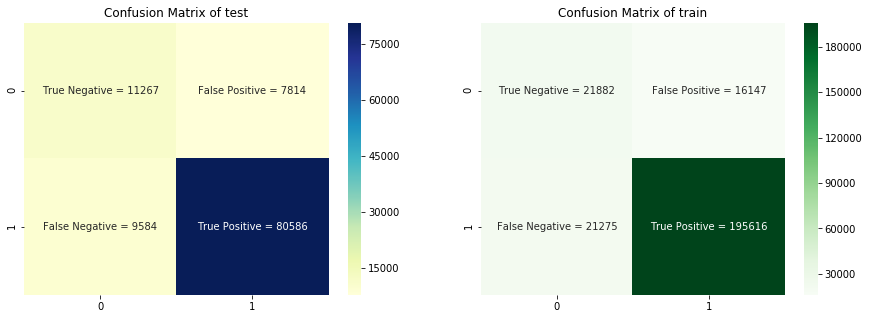

In [34]:
CM(test['Score'],pred1,train['Score'],pred)

## Feature Importance:

Top 20 important features are : 



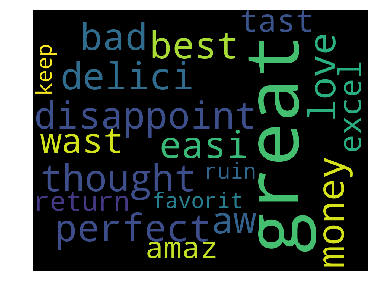

In [74]:
feat_importance(tf_GB,tfidf)

# Building W2V Model:

In [42]:
from gensim.models import Word2Vec

In [43]:
#Creating sentence list

sentence_list=[]
for sentence in train['New']:
    sentence_list.append(sentence.split())

#sentence_list[5]


In [44]:
w2v=Word2Vec(sentence_list,size=200,min_count=1,workers=4)

In [45]:
w2v_list=list(w2v.wv.vocab)

In [26]:
len(w2v_list)

55208

# 3.) Average W2V Vectorization:

In [29]:
def avgwv(x):
    '''
    To calculate average word 2 vector model
    '''
    sent_vect=[]
    for sentence in x:
        count=0;
        s_v=np.zeros(200)
        for words in sentence.split():
            if words in w2v_list:
                V=w2v.wv[words]
                count+=1
                s_v+=V
            if (count!=0):
                s_v/=count
        sent_vect.append(s_v)
    return(sent_vect)
                    

In [30]:
train_w2v=avgwv(train['New'])

In [31]:
test_w2v=avgwv(test['New'])

In [41]:
with open(r'G:\ML\Pickles\Avgw2v_200d.pickle','rb') as f:
    train_w2v,test_w2v=pickle.load(f)

In [42]:
scaler=StandardScaler(with_mean=False)
std_train_avgw2v=scaler.fit_transform(train_w2v)
std_test_avgw2v=scaler.transform(test_w2v)

### Cross Validation :

In [34]:
avg1_grid=RF_grid(std_train_avgw2v[:100000])

In [35]:
avg1_grid.fit(std_train_avgw2v[:100000],train['Score'][:100000])

Fitting 3 folds for each of 36 candidates, totalling 108 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  5.3min
[Parallel(n_jobs=-1)]: Done 108 out of 108 | elapsed: 17.7min finished


GridSearchCV(cv=<generator object TimeSeriesSplit.split at 0x7fe2759e6c50>,
       error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators='warn', n_jobs=None, oob_score=False,
            random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid=[{'n_estimators': [5, 10, 20, 30, 50, 75], 'max_depth': [10, 20, 25, 30, 40, 50]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='f1_micro', verbose=1)

In [36]:
avg1_grid.best_estimator_

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=40, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=75, n_jobs=None, oob_score=False,
            random_state=None, verbose=0, warm_start=False)

In [37]:
avg1_grid.best_score_

0.8710666666666667

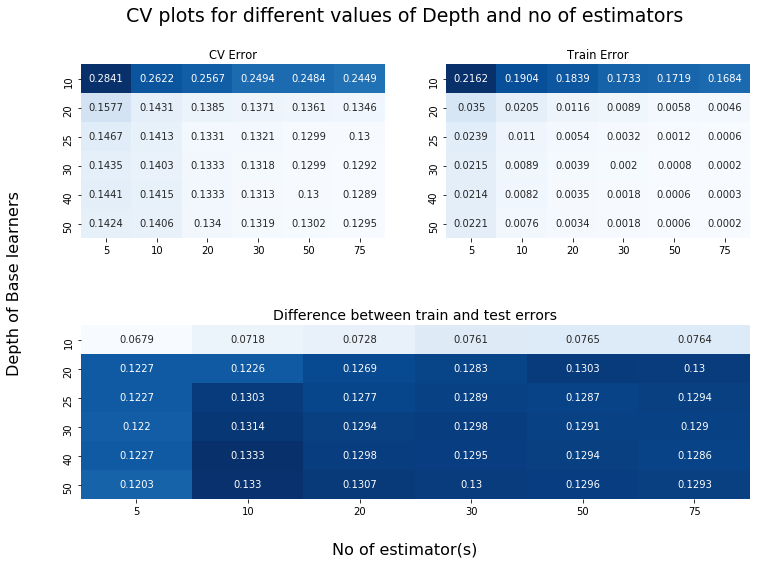

In [38]:
error_plots(avg1_grid)

From above plots, in CV error plot we can see that there is a dip of error at around depth =25 for 10 and 20 estimators. So we select <b> max_depth = 25 </b>. And for number of estimators we can observe that the erro decrease rapidly until 20, post which the error is falling very slowly. Hence <b> no of estimators = 20 </b>.

### Implementation:

In [15]:
model=RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=25, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=20, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [16]:
model.fit(std_train_avgw2v,train['Score'])

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=25, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=20, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [17]:
pred=model.predict(std_test_avgw2v)
pred1=model.predict(std_train_avgw2v)


******************************************************************************* 

 Accuracy of train is 0.9888945551545583

 Accuracy of test is 0.8261709274972312

******************************************************************************* 

Classification report of train is 

             precision    recall  f1-score   support

   Negative       0.96      0.96      0.96     38029
   Positive       0.99      0.99      0.99    216891

avg / total       0.99      0.99      0.99    254920


******************************************************************************* 

Classification report of test is 

             precision    recall  f1-score   support

   Negative       0.51      0.23      0.32     19081
   Positive       0.85      0.95      0.90     90170

avg / total       0.79      0.83      0.80    109251


******************************************************************************* 

Heat Map of the Confusion matrix is

************************************************

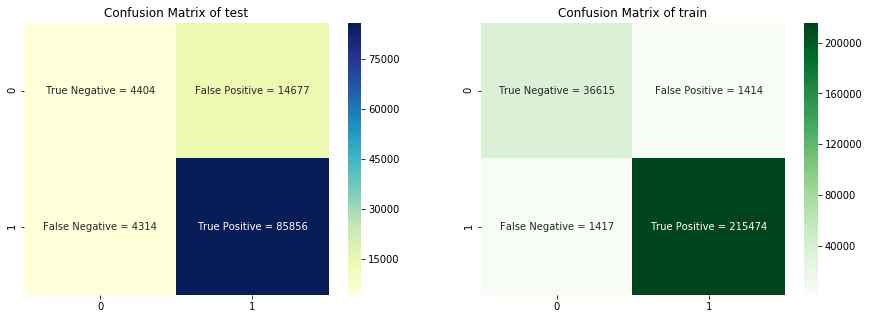

In [18]:
CM(test['Score'],pred,train['Score'],pred1)

The model doesn't perform well with negatives on test data as there are few True negatives and many False negatives. From train CM, we can see that the model seems to be a little overfitting so we will take the depth as 25 and no of estimators as 10 and see how model is performing.

In [19]:
model=RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=25, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [20]:
model.fit(std_train_avgw2v,train['Score'])

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=25, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [21]:
pred=model.predict(std_test_avgw2v)
pred1=model.predict(std_train_avgw2v)

## Performace of RF model with Avg W2V:


******************************************************************************* 

 Accuracy of train is 0.9785815157696532

 Accuracy of test is 0.8176218066653852

******************************************************************************* 

Classification report of train is 

             precision    recall  f1-score   support

   Negative       0.94      0.92      0.93     38029
   Positive       0.99      0.99      0.99    216891

avg / total       0.98      0.98      0.98    254920


******************************************************************************* 

Classification report of test is 

             precision    recall  f1-score   support

   Negative       0.46      0.25      0.32     19081
   Positive       0.86      0.94      0.89     90170

avg / total       0.79      0.82      0.79    109251


******************************************************************************* 

Heat Map of the Confusion matrix is

************************************************

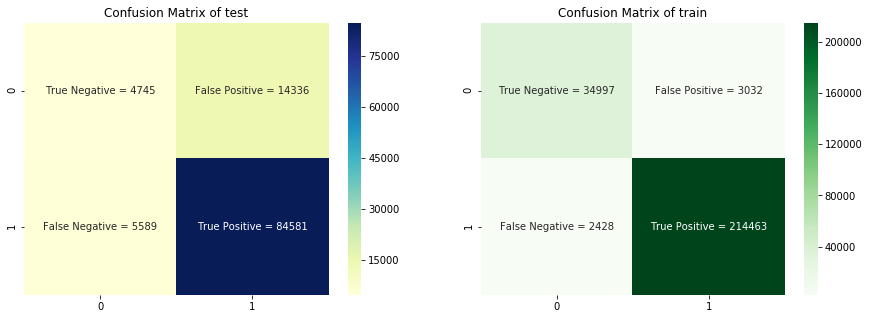

In [22]:
CM(test['Score'],pred,train['Score'],pred1)

Though the model is slightly better than the earlier one, still it is performing poor on negative points. We can infer that Avg word 2 vec is not a better one for this data to be applied with RF.

### GBDT

### Cross Validation :

In [29]:
avg_grid=GB_grid(std_train_avgw2v[0:100000])

In [30]:
avg_grid.fit(std_train_avgw2v[0:100000],train['Score'][0:100000])

Fitting 3 folds for each of 25 candidates, totalling 75 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  6.9min
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed: 46.6min finished


GridSearchCV(cv=<generator object TimeSeriesSplit.split at 0x7f13a483f620>,
       error_score='raise-deprecating',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic',
       random_state=33, reg_alpha=0, reg_lambda=1, scale_pos_weight=0.25,
       seed=None, silent=True, subsample=1),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid=[{'n_estimators': [10, 25, 50, 100, 200], 'max_depth': [1, 3, 5, 7, 9]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='f1_micro', verbose=2)

In [31]:
avg_grid.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=1, min_child_weight=1, missing=None, n_estimators=10,
       n_jobs=1, nthread=None, objective='binary:logistic',
       random_state=33, reg_alpha=0, reg_lambda=1, scale_pos_weight=0.25,
       seed=None, silent=True, subsample=1)

In [32]:
avg_grid.best_score_

0.8731733333333334

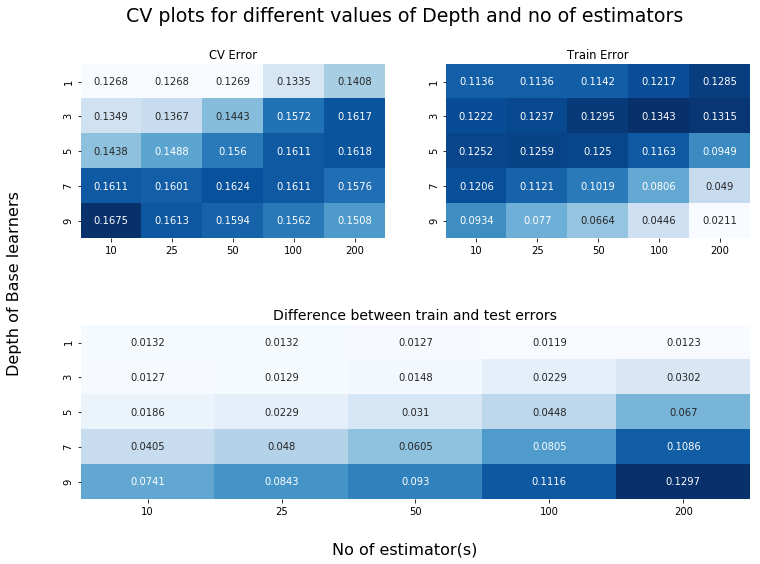

In [33]:
error_plots(avg_grid)

From CV plot, we can say that the error is low at first 3 values .We will consider the optimal values as 

<b>
Depth =1 and No of estimators=50
</b>

as it is where the error is a little closer between train and test and also CV error is less.

### Implementation:

In [46]:
avg_GB=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=1, min_child_weight=1, missing=None, n_estimators=50,
       n_jobs=1, nthread=None, objective='binary:logistic',
       random_state=33, reg_alpha=0, reg_lambda=1, scale_pos_weight=0.25,
       seed=None, silent=True, subsample=1)

In [47]:
avg_GB.fit(std_train_avgw2v,train['Score'])

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=1, min_child_weight=1, missing=None, n_estimators=50,
       n_jobs=1, nthread=None, objective='binary:logistic',
       random_state=33, reg_alpha=0, reg_lambda=1, scale_pos_weight=0.25,
       seed=None, silent=True, subsample=1)

In [48]:
pred=avg_GB.predict(std_test_avgw2v)
pred1=avg_GB.predict(std_train_avgw2v)

## Performance of GBDT model with Tf-Idf W2V:


******************************************************************************* 

 Accuracy of train is 0.8142672210889691

 Accuracy of test is 0.7949217856129464

******************************************************************************* 

Classification report of train is 

             precision    recall  f1-score   support

   Negative       0.35      0.27      0.30     38029
   Positive       0.88      0.91      0.89    216891

avg / total       0.80      0.81      0.81    254920


******************************************************************************* 

Classification report of test is 

             precision    recall  f1-score   support

   Negative       0.38      0.28      0.32     19081
   Positive       0.86      0.90      0.88     90170

avg / total       0.77      0.79      0.78    109251


******************************************************************************* 

Heat Map of the Confusion matrix is

************************************************

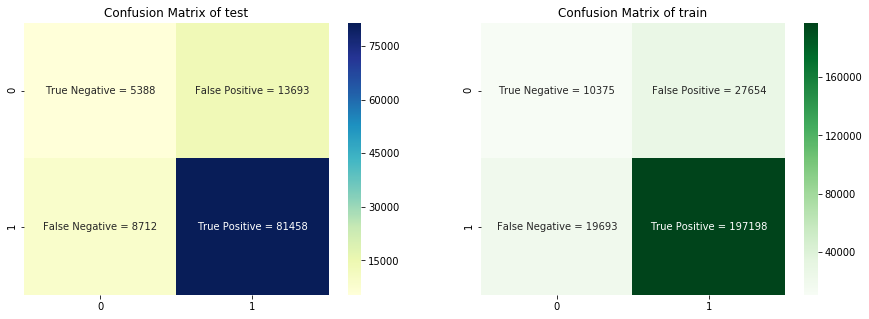

In [49]:
CM(test['Score'],pred,train['Score'],pred1)

# 5.) Tf-IDF weighted Word2Vec Vectorization:

In [37]:
dictionary = dict(zip(tfidf.get_feature_names(), list(tfidf.idf_)))

In [40]:
features=tfidf.get_feature_names()

def tfidf_w2v(x):
    '''
    To calculate Tf-IDf weighted word2vec for a review
    '''     
    row=0
    sentence_vectors=[]
    for sentences in x:
        weight=0
        s_v=np.zeros(200)
        for words in sentences.split():
            if words in w2v_list:
                try:
                    v=w2v.wv[words]
                    #tfidf_value=y[row,features.index(words)]
                    tfidf_value = dictionary[words]*sentences.count(words)
                    s_v+=(v*tfidf_value)
                    weight+=tfidf_value
                except(KeyError):
                    continue                
            else:
                continue
        if(weight!=0):
            s_v/=weight
        sentence_vectors.append(s_v)
        row+=1
    return sentence_vectors
                
    
    

In [60]:
with open(r'G:\ML\Pickles\tfidfw2v_train_200d.pickle','rb') as f:
    train_tfidf_w2v=pickle.load(f)

In [61]:
with open(r'G:\ML\Pickles\tfidfw2v_test_200d.pickle','rb') as f:
    test_tfidf_w2v=pickle.load(f)

In [62]:
scaler=StandardScaler(with_mean=False)
std_train_tfidfw2v=scaler.fit_transform(train_tfidf_w2v)
std_test_tfidfw2v=scaler.transform(test_tfidf_w2v)

### Cross validation:

In [41]:
tfidf_w2v_grid=RF_grid(std_train_tfidfw2v[:100000])

In [42]:
tfidf_w2v_grid.fit(std_train_tfidfw2v[:100000],train['Score'][:100000])

Fitting 3 folds for each of 36 candidates, totalling 108 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  5.2min
[Parallel(n_jobs=-1)]: Done 108 out of 108 | elapsed: 17.3min finished


GridSearchCV(cv=<generator object TimeSeriesSplit.split at 0x7fe23283b3b8>,
       error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators='warn', n_jobs=None, oob_score=False,
            random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid=[{'n_estimators': [5, 10, 20, 30, 50, 75], 'max_depth': [10, 20, 25, 30, 40, 50]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='f1_micro', verbose=1)

In [43]:
tfidf_w2v_grid.best_score_

0.88988

In [44]:
tfidf_w2v_grid.best_estimator_

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=20, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=30, n_jobs=None, oob_score=False,
            random_state=None, verbose=0, warm_start=False)

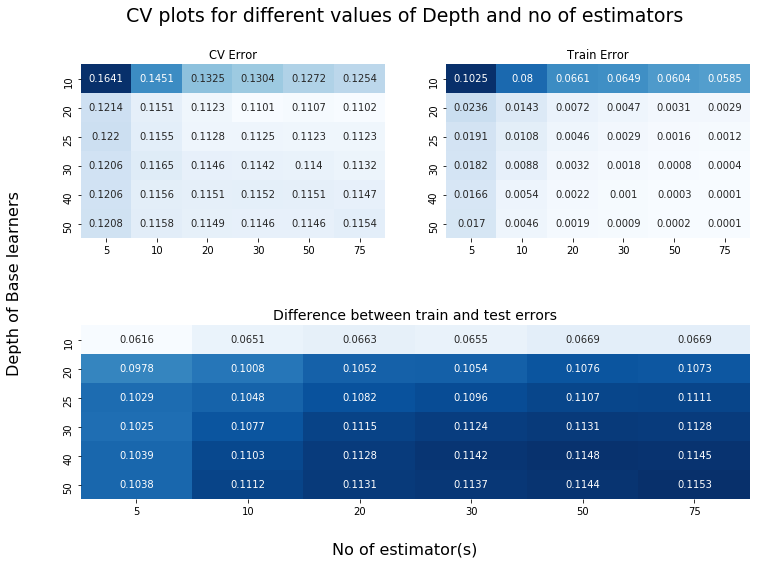

In [45]:
error_plots(tfidf_w2v_grid)

From above plot we can pick the optimal values for <b> depth as 20 and no of estimators as 20 </b> as after that error starts decreasing slowly.

### Implementation:

In [58]:
tfidf_w2v_model=RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=20, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=20, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [63]:
tfidf_w2v_model.fit(std_train_tfidfw2v,train['Score'])

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=20, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=20, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [64]:
pred=tfidf_w2v_model.predict(std_test_tfidfw2v)
pred1=tfidf_w2v_model.predict(std_train_tfidfw2v)


******************************************************************************* 

 Accuracy of train is 0.98773732935823

 Accuracy of test is 0.8248986279301791

******************************************************************************* 

Classification report of train is 

             precision    recall  f1-score   support

   Negative       0.94      0.98      0.96     38029
   Positive       1.00      0.99      0.99    216891

avg / total       0.99      0.99      0.99    254920


******************************************************************************* 

Classification report of test is 

             precision    recall  f1-score   support

   Negative       0.22      0.00      0.00     19081
   Positive       0.83      1.00      0.90     90170

avg / total       0.72      0.82      0.75    109251


******************************************************************************* 

Heat Map of the Confusion matrix is

**************************************************

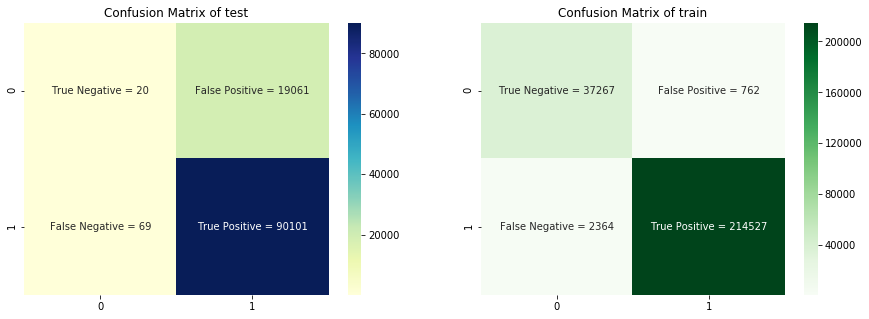

In [65]:
CM(test['Score'],pred,train['Score'],pred1)

Even with 20 estimators, the model seems to be performing poor. Let's take furthermore lower value like 10.

In [80]:
tfidf_w2v_model=RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=15, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=5, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [81]:
tfidf_w2v_model.fit(std_train_tfidfw2v,train['Score'])

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=15, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=5, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [82]:
pred=tfidf_w2v_model.predict(std_test_tfidfw2v)
pred1=tfidf_w2v_model.predict(std_train_tfidfw2v)


******************************************************************************* 

 Accuracy of train is 0.9313157068884356

 Accuracy of test is 0.7534484810207687

******************************************************************************* 

Classification report of train is 

             precision    recall  f1-score   support

   Negative       0.72      0.89      0.79     38029
   Positive       0.98      0.94      0.96    216891

avg / total       0.94      0.93      0.93    254920


******************************************************************************* 

Classification report of test is 

             precision    recall  f1-score   support

   Negative       0.17      0.11      0.14     19081
   Positive       0.83      0.89      0.86     90170

avg / total       0.71      0.75      0.73    109251


******************************************************************************* 

Heat Map of the Confusion matrix is

************************************************

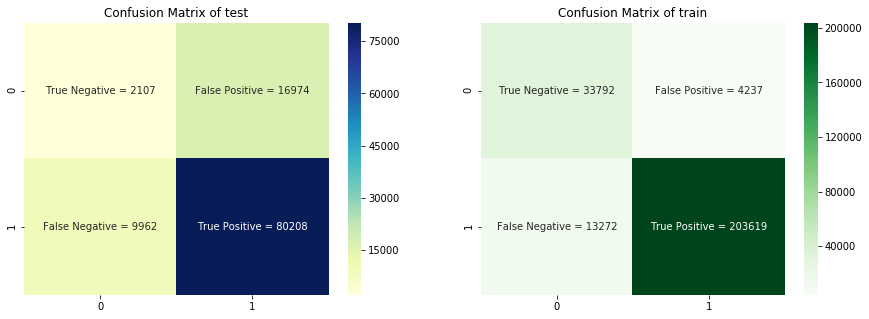

In [83]:
CM(test['Score'],pred,train['Score'],pred1)

Since the model is overfitting,it is completely biased towards positive class. We will decrease the number of estimators to see how its doing.

In [72]:
tfidf_w2v_model=RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=20, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=5, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [73]:
tfidf_w2v_model.fit(std_train_tfidfw2v,train['Score'])

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=20, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=5, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [74]:
pred=tfidf_w2v_model.predict(std_test_tfidfw2v)
pred1=tfidf_w2v_model.predict(std_train_tfidfw2v)


******************************************************************************* 

 Accuracy of train is 0.9684096971598933

 Accuracy of test is 0.7812285471071203

******************************************************************************* 

Classification report of train is 

             precision    recall  f1-score   support

   Negative       0.88      0.91      0.90     38029
   Positive       0.98      0.98      0.98    216891

avg / total       0.97      0.97      0.97    254920


******************************************************************************* 

Classification report of test is 

             precision    recall  f1-score   support

   Negative       0.17      0.07      0.10     19081
   Positive       0.83      0.93      0.88     90170

avg / total       0.71      0.78      0.74    109251


******************************************************************************* 

Heat Map of the Confusion matrix is

************************************************

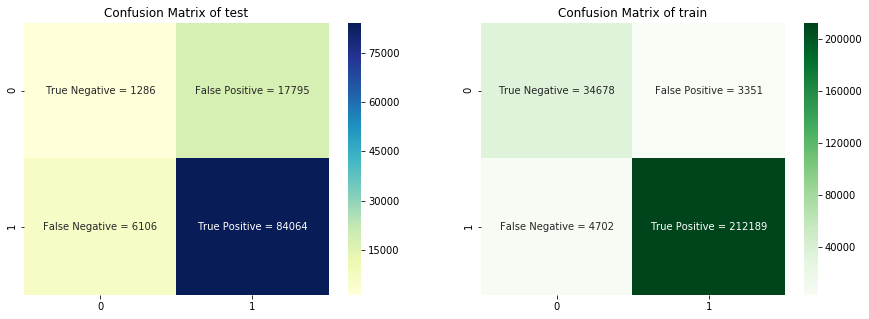

In [75]:
CM(test['Score'],pred,train['Score'],pred1)

With just 5 estimators, training seems to be good but it performs poor on test data especially for negative classes. Lets try to reduce max_depth parameter and see if we get a good result.

In [31]:
tfidf_w2v_model=RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=20, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [32]:
tfidf_w2v_model.fit(std_train_tfidfw2v,train['Score'])

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=20, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [33]:
pred=tfidf_w2v_model.predict(std_test_tfidfw2v)
pred1=tfidf_w2v_model.predict(std_train_tfidfw2v)

## Performance of RF model with Tf-Idf W2V:


******************************************************************************* 

 Accuracy of train is 0.9802134002824415

 Accuracy of test is 0.8183906783461936

******************************************************************************* 

Classification report of train is 

             precision    recall  f1-score   support

   Negative       0.93      0.94      0.93     38029
   Positive       0.99      0.99      0.99    216891

avg / total       0.98      0.98      0.98    254920


******************************************************************************* 

Classification report of test is 

             precision    recall  f1-score   support

   Negative       0.19      0.01      0.02     19081
   Positive       0.83      0.99      0.90     90170

avg / total       0.71      0.82      0.75    109251


******************************************************************************* 

Heat Map of the Confusion matrix is

************************************************

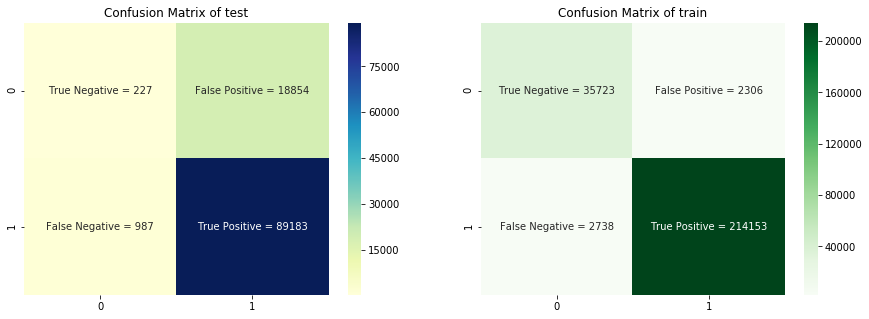

In [34]:
CM(test['Score'],pred,train['Score'],pred1)

Atleast with n=10, the model is predicting very few points as negative. From this we can infer that this <b> TfIdf W2v vectorization perform poor with RF algorithm.

### GBDT

### Cross Validation :

In [36]:
tfidf_grid=GB_grid(std_train_tfidfw2v[0:100000])

In [37]:
tfidf_grid.fit(std_train_tfidfw2v[0:100000],train['Score'][0:100000])

Fitting 3 folds for each of 25 candidates, totalling 75 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  7.2min
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed: 48.1min finished


GridSearchCV(cv=<generator object TimeSeriesSplit.split at 0x7f13977f14c0>,
       error_score='raise-deprecating',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic',
       random_state=33, reg_alpha=0, reg_lambda=1, scale_pos_weight=0.25,
       seed=None, silent=True, subsample=1),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid=[{'n_estimators': [10, 25, 50, 100, 200], 'max_depth': [1, 3, 5, 7, 9]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='f1_micro', verbose=2)

In [38]:
tfidf_grid.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=9, min_child_weight=1, missing=None, n_estimators=200,
       n_jobs=1, nthread=None, objective='binary:logistic',
       random_state=33, reg_alpha=0, reg_lambda=1, scale_pos_weight=0.25,
       seed=None, silent=True, subsample=1)

In [39]:
tfidf_grid.best_score_

0.9058933333333333

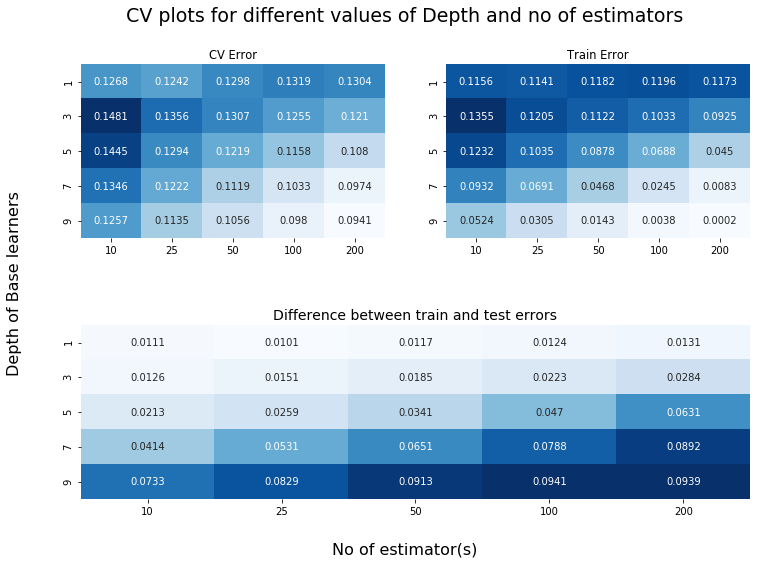

In [40]:
error_plots(tfidf_grid)

We can infer that both row wose and column wise the inflection occurs at depth =3 and n_esimatiors =25 after which the error starts decreasing steadily.

### Implementation:

In [45]:
tfidf_model=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=25,
       n_jobs=1, nthread=None, objective='binary:logistic',
       random_state=33, reg_alpha=0, reg_lambda=1, scale_pos_weight=0.25,
       seed=None, silent=True, subsample=1)

In [46]:
tfidf_model.fit(std_train_tfidfw2v,train['Score'])

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=25,
       n_jobs=1, nthread=None, objective='binary:logistic',
       random_state=33, reg_alpha=0, reg_lambda=1, scale_pos_weight=0.25,
       seed=None, silent=True, subsample=1)

In [47]:
pred=tfidf_model.predict(std_test_tfidfw2v)
pred1=tfidf_model.predict(std_train_tfidfw2v)


******************************************************************************* 

 Accuracy of train is 0.8254825043150792

 Accuracy of test is 0.6752981666071707

******************************************************************************* 

Classification report of train is 

             precision    recall  f1-score   support

   Negative       0.44      0.62      0.52     38029
   Positive       0.93      0.86      0.89    216891

avg / total       0.86      0.83      0.84    254920


******************************************************************************* 

Classification report of test is 

             precision    recall  f1-score   support

   Negative       0.16      0.20      0.18     19081
   Positive       0.82      0.78      0.80     90170

avg / total       0.71      0.68      0.69    109251


******************************************************************************* 

Heat Map of the Confusion matrix is

************************************************

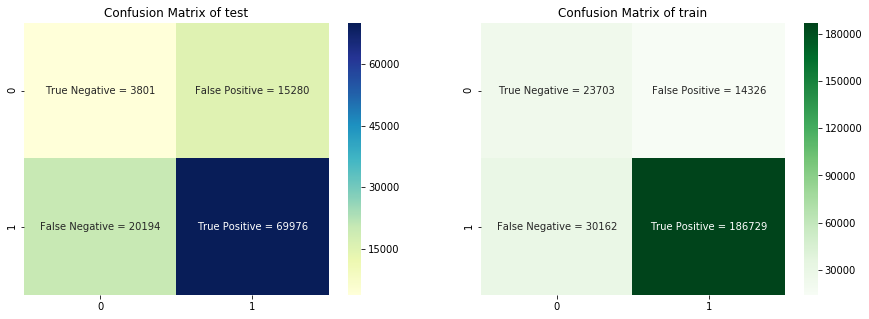

In [48]:
CM(test['Score'],pred,train['Score'],pred1)

The model is performing too poor and even it is not that good with training, So we will increase the no of estimators to 50.

In [89]:
tfidf_model=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=50,
       n_jobs=1, nthread=None, objective='binary:logistic',
       random_state=33, reg_alpha=0, reg_lambda=1, scale_pos_weight=0.25,
       seed=None, silent=True, subsample=1)

In [90]:
tfidf_model.fit(std_train_tfidfw2v,train['Score'])

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=50,
       n_jobs=1, nthread=None, objective='binary:logistic',
       random_state=33, reg_alpha=0, reg_lambda=1, scale_pos_weight=0.25,
       seed=None, silent=True, subsample=1)

In [91]:
pred2=tfidf_model.predict(std_test_tfidfw2v)

In [92]:
pred=tfidf_model.predict(std_train_tfidfw2v)


******************************************************************************* 

 Accuracy of train is 0.8400439353522674

 Accuracy of test is 0.613285004256254

******************************************************************************* 

Classification report of train is 

             precision    recall  f1-score   support

   Negative       0.47      0.67      0.56     38029
   Positive       0.94      0.87      0.90    216891

avg / total       0.87      0.84      0.85    254920


******************************************************************************* 

Classification report of test is 

             precision    recall  f1-score   support

   Negative       0.16      0.28      0.20     19081
   Positive       0.82      0.68      0.74     90170

avg / total       0.70      0.61      0.65    109251


******************************************************************************* 

Heat Map of the Confusion matrix is

*************************************************

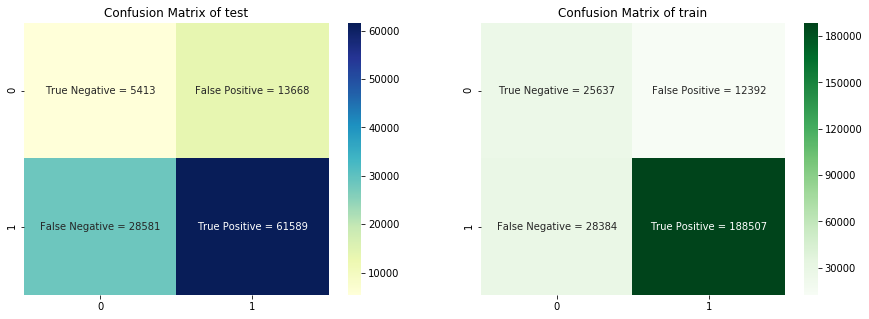

In [93]:
CM(test['Score'],pred2,train['Score'],pred)

## Performace of GBDT model with Tf-IDF W2V:


******************************************************************************* 

 Accuracy of train is 0.8254825043150792

 Accuracy of test is 0.6752981666071707

******************************************************************************* 

Classification report of train is 

             precision    recall  f1-score   support

   Negative       0.44      0.62      0.52     38029
   Positive       0.93      0.86      0.89    216891

avg / total       0.86      0.83      0.84    254920


******************************************************************************* 

Classification report of test is 

             precision    recall  f1-score   support

   Negative       0.16      0.20      0.18     19081
   Positive       0.82      0.78      0.80     90170

avg / total       0.71      0.68      0.69    109251


******************************************************************************* 

Heat Map of the Confusion matrix is

************************************************

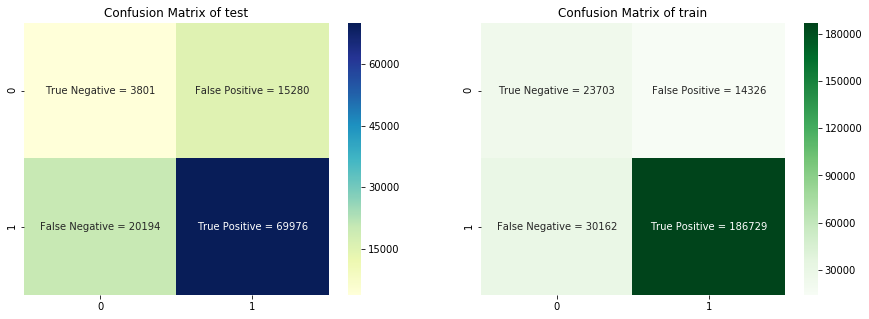

In [48]:
CM(test['Score'],pred,train['Score'],pred1)

After increasing no of estimators, the number of True negatives increased but Positive class suffer much. So we can't use tfidf weighted w2v with GBDT effectively.

# Performace comparision between different vectorizations::

In [94]:
tmp=pd.DataFrame(columns=['Type of Vectorization','Model','Optimal depth','Opt. No of estimators','Train Accuracy','Test Accuracy','Train F1 Score','Test F1 score'])
tmp.loc[0]=['BOW_Unigram','RF',30,30,0.884,0.850,0.89,0.86]
tmp.loc[1]=['BOW_Unigram','GBDT',3,50,0.859,0.845,0.86,0.85]
tmp.loc[2]=['Tf-IDF','RF',20,20,0.890,0.851,0.89,0.86]
tmp.loc[3]=['Tf-IDF','GBDT',3,50,0.853,0.840,0.86,0.84]
tmp.loc[4]=['Avg_W2v','RF',25,10,0.988,0.826,0.99,0.80]
tmp.loc[5]=['Avg_W2v','GBDT',7,50,0.814,0.794,0.81,0.78]
tmp.loc[6]=['Tf-IDF_W2v','RF',20,10,0.98,0.81,0.98,0.75]
tmp.loc[7]=['Tf-IDF_W2v','GBDT',3,100,0.825,0.675,0.84,0.69]

In [95]:
tmp

,Type of Vectorization,Model,Optimal depth,Opt. No of estimators,Train Accuracy,Test Accuracy,Train F1 Score,Test F1 score
0,BOW_Unigram,RF,30,30,0.884,0.850,0.89,0.86
1,BOW_Unigram,GBDT,3,50,0.859,0.845,0.86,0.85
2,Tf-IDF,RF,20,20,0.890,0.851,0.89,0.86
3,Tf-IDF,GBDT,3,50,0.853,0.840,0.86,0.84
4,Avg_W2v,RF,25,10,0.988,0.826,0.99,0.80
5,Avg_W2v,GBDT,7,50,0.814,0.794,0.81,0.78
6,Tf-IDF_W2v,RF,20,10,0.980,0.810,0.98,0.75
7,Tf-IDF_W2v,GBDT,3,100,0.825,0.675,0.84,0.69


# Conclusion from above exercise:

1.) BOW unigram with RF well separates both the classes.

2.) The performance of Tf-IDF vectorization with both the models seem to be good.

3.) Both types of Word2Vec vectorizations perform too poor for both the models and they are not appropraite for this data with ensemble models.


*****************************************************************************************************************************

#### From above exercise I conclude that "BOW_Unigram " can be used with Random forest model as it is highest on accuracy & F1 score comparision with others.Even True positive and True negatives are more.
